In [35]:
# %%time
dataset_name = "W20_only"
df_list = "BES_Panel|BES_reduced|BES_reduced_with_na"

%matplotlib inline 
%run BES_header.py {dataset_name} {df_list}
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)    


# if "id" in BES_Panel.columns:
#     BES_Panel = BES_Panel.set_index("id").sort_index()


    
# get full set of inferred "cross wave" auth-lib/left-right values and ages
pan_dataset_allr_values = pd.read_pickle(BES_small_data_files + "pan_dataset_allr_valuesW19"+".zip",compression='zip')
# pan_dataset_allr_values = pan_dataset_allr_values.loc[BES_Panel.index].sort_index()
pan_dataset_ages = pd.read_pickle(BES_small_data_files + "pan_dataset_ages"+".zip", compression='zip')
pan_dataset_votes = pd.read_pickle(BES_small_data_files+"pan_dataset_votes"+".zip",compression='zip')

# BES_Panel = pd.read_pickle("..\\BES_analysis_data\\"+"W19_comb"+os.sep+"BES_Panelv02",compression='zip')
# BES_Panel = BES_Panel.set_index("id")
# BES_Panel = BES_Panel.sort_index()


Toggle code

var_type (463, 14)


In [36]:
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding) 

var_type (463, 14)


In [37]:
def get_dta_meta(fn):
    reader = pd.io.stata.StataReader( fn )
    header = reader.variable_labels()
    labels = reader.value_labels()
    return header,labels
BESheader,BESlabels = get_dta_meta(BES_data_folder+"W20_only"+os.sep+"BES2019_W20_v0.1-3.dta")

In [69]:
def useBESheaders(x, ambiguous=[]):
    if "__" in x:
        out= BESheader[x.split("__")[0]].replace("â\x80\x99","'")
    elif "_" in x:
        out= BESheader["_".join(x.split("_")[:-1])].replace("â\x80\x99","'")+"("+x.split("_")[-1]+")"
    elif x in BESheader.keys():
        out =BESheader[x].replace("â\x80\x99","'")
    else:
        out= x
    
    if out in ambiguous:
        out = "{"+x+"}"+out
    return out

Wall time: 7.48 s


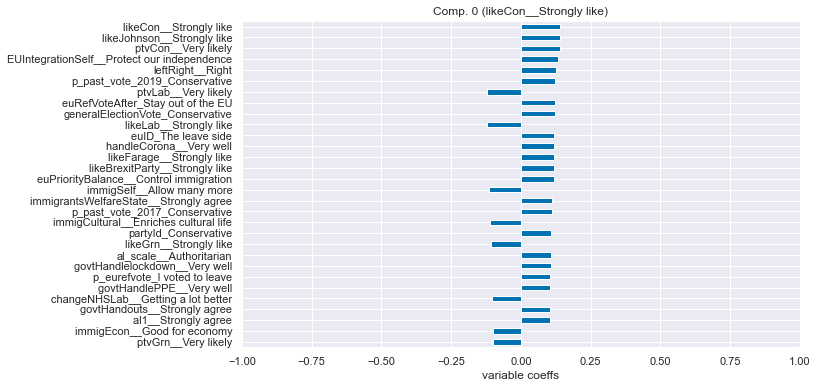

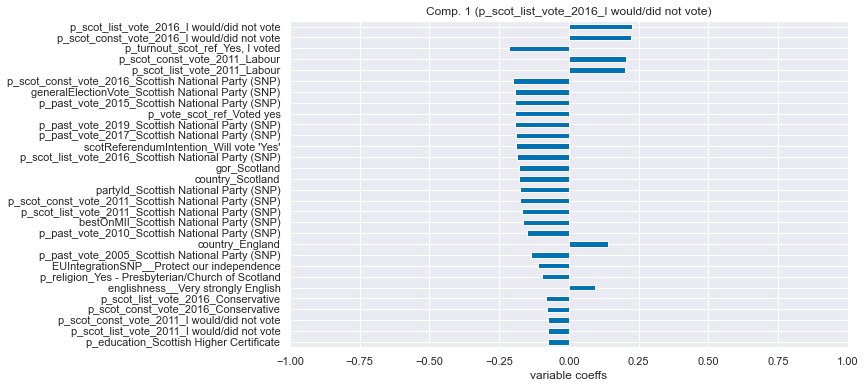

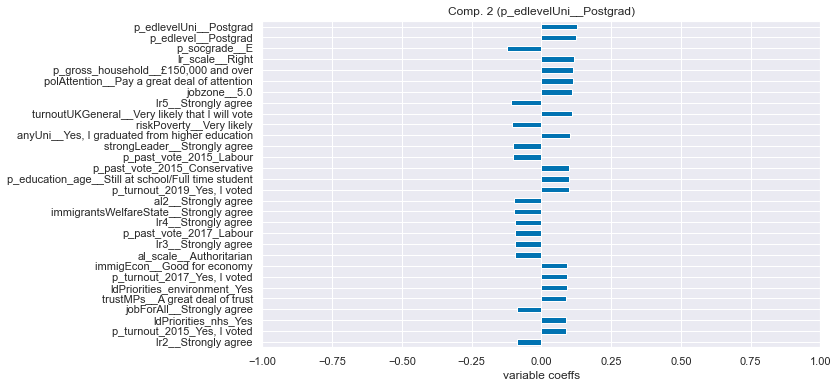

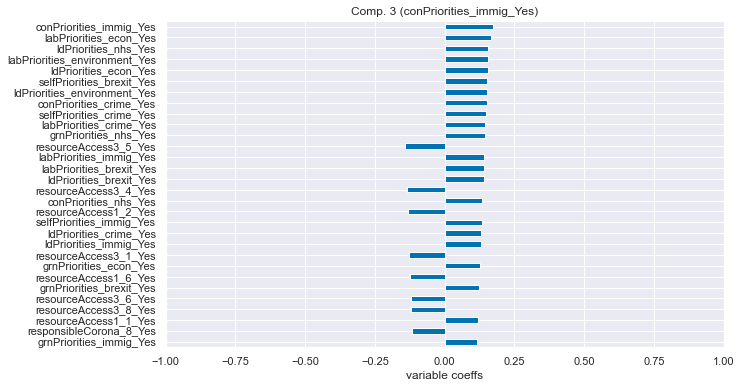

In [38]:
%%time

Treatment = "Wave 20 First Look"
output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

# value_vars = [x for x in manifesto_project.columns if re.match("per(\d+|uncod)|rile|planeco|markeco|welfare|intpeace",x)]
# value_vars = search(BES_reduced_with_na,"taxSpend|tax(Low|Middle|High)Income|bes(1|2|3|4)(a|b)W2|socialCare|howToReduceDeficit|deficitReduce|spend(Health|Pensions|Unemp)").index
# # rile, planeco, markeco, welfare, intpeace
# # notnulls = BES_reduced_with_na[value_vars].notnull().any(axis=1)
# notnulls = BES_reduced_with_na["taxLowIncomeW15__Much too high"].notnull()
# MCP_vals = BES_reduced_with_na[value_vars][notnulls]
# MCP_vals = MCP_vals.fillna(MCP_vals.mean())
# # df["peruncod"]
# # percentage uncoded
# # MCP_vals.columns = [variable_labels.loc[x]+"("+x.replace("per","")+")" for x in MCP_vals.columns]
# # MCP_vals.columns
# MCP_vals = MCP_vals.drop_duplicates()

MCP_vals = BES_reduced


decomp_index = MCP_vals.index
decomp_columns = MCP_vals.columns
clean_feature_set_std = StandardScaler().fit_transform(MCP_vals.values )
decomp_std = pd.DataFrame(   clean_feature_set_std,
                             columns = MCP_vals.columns,
                             index   = MCP_vals.index      )



# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = decomp_std.shape[1]
n_components = 4
# (svd_solver='full', n_components='mle',whiten=True)
decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=2,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

# decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(decomp_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = decomp_index)


import pickle
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_hdf(fname+".hdf"        , decomp_method)
    decomp_std.to_hdf(   fname+"_std"+".hdf" , decomp_method)
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    decomp_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 
    
    
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          decomp_columns, BES_decomp, manifest=None, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 7, show_histogram = False)    

explained variance ratio (first 30): [0.04601122 0.01890525 0.01671997 0.01522535]
explained variance (first 30): [34.141396 14.028132 12.406604 11.29756 ]
average log-likelihood of all samples: -1022.81055


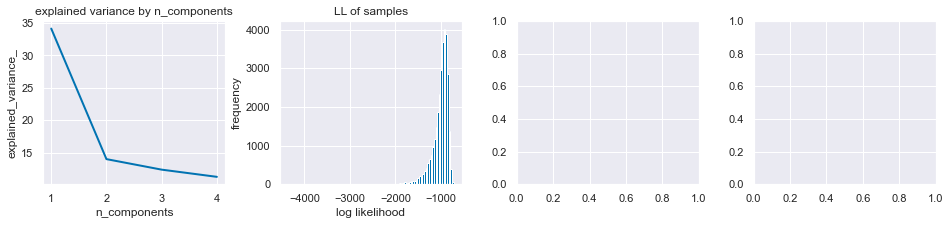

In [39]:
display_pca_data(n_components,decomp,decomp_std)

In [40]:
## Look at the correlates/coverage of some interesting variables

In [41]:
search(BES_reduced_with_na, "handleCorona" )

handleCorona__Very well       30817
handleCoronaLab__Very well    24976
dtype: int64

In [42]:
%%time

pattern = "handleCorona__Very well"
name = "handleCorona__Very well"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na,
                                 name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
govtHandlelockdown__Very well,0.800000,0.00,30587
likeJohnson__Strongly like,0.760000,0.00,30130
govtHandleTesting__Very well,0.740000,0.00,30155
govtHandlePPE__Very well,0.730000,0.00,30127
benchCoronaUK__Very good,0.720000,0.00,7477
likeCon__Strongly like,0.720000,0.00,29498
ptvCon__Very likely,0.680000,0.00,28680
generalElectionVote_Conservative,0.670000,0.00,24774
conLookAfterBA__Very closely,0.640000,0.00,5990
bestOnMII_Conservative,0.610000,0.00,24126


Wall time: 9.05 s


In [43]:
search(BES_reduced_with_na, "corona" ).sort_values()

benchCoronaKorea__Very good              6310
benchCoronaSweden__Very good             6441
benchCoronaChina__Very good              6865
benchCoronaGermany__Very good            6903
responsibleCorona_10_Yes                 7108
responsibleCorona_1_Yes                  7108
responsibleCorona_2_Yes                  7108
responsibleCorona_6_Yes                  7108
responsibleCorona_7_Yes                  7108
responsibleCorona_8_Yes                  7108
responsibleCorona_111_Yes                7108
benchCoronaItaly__Very good              7133
benchCoronaUSA__Very good                7372
benchCoronaUK__Very good                 7572
dependentsCoronavirus_Yes                8341
workHomeCoronaPartner_Yes                9767
workHomeCoronaSelf_Yes                  12635
handleCoronaLab__Very well              24976
coronaMeasures_none_Yes                 29295
coronaMeasures_2_Yes                    29295
coronaMeasures_5_Yes                    29295
coronaMeasures_4_Yes              

No            26222
Yes            4019
Don't know      937
Name: coronaDied, dtype: int64

In [45]:
search(BES_reduced_with_na, "cvSeverity" ).sort_values()

cvSeverityClose__They passed away       1997
cvSeveritySelf__Required ventilation    4387
cvSeverityFamily__They passed away      5427
dtype: int64

In [46]:
BES_Panel["cvSeverityClose"].value_counts()

Most daily activities were not possible    660
Had to stop some daily activities          629
Could still do all daily activities        381
Required hospitalisation                   146
They passed away                           138
Don't know                                  62
Required ventilation                        43
Name: cvSeverityClose, dtype: int64

In [47]:
BES_Panel["cvSeveritySelf"].value_counts()

Could still do all daily activities        1761
Had to stop some daily activities          1484
Most daily activities were not possible    1072
Don't know                                   90
Required hospitalisation                     63
Required ventilation                          7
Name: cvSeveritySelf, dtype: int64

In [48]:
BES_Panel["cvSeverityFamily"].value_counts()

Had to stop some daily activities          1944
Most daily activities were not possible    1702
Could still do all daily activities        1321
Required hospitalisation                    253
They passed away                            167
Don't know                                   84
Required ventilation                         40
Name: cvSeverityFamily, dtype: int64

In [49]:
%%time

pattern = "worryCoronaHealth__Extremely Worried"
name = "worryCoronaHealth__Extremely Worried"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na,
                                 name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
worryCoronaPub__Extremely Worried,0.370000,0.00,30623
lockdownApproval__10 - Strongly support lockdown,0.350000,0.00,7539
coronaMeasures2_4_Yes,0.280000,0.00,29252
dutyCorona__Strongly agree,0.270000,0.00,30459
coronaMeasures_3_Yes,0.240000,0.00,29116
coronaMeasures2_3_Yes,0.240000,0.00,29252
coronaMeasures_5_Yes,0.240000,0.00,29116
coronaMeasures_2_Yes,0.240000,0.00,29116
coronaMeasures_4_Yes,0.240000,0.00,29116
coronaMeasures2_2_Yes,0.230000,0.00,29252


Wall time: 9.01 s


In [50]:
search(BES_reduced_with_na, "highRiskMedical" ).sort_values()
BES_Panel["highRiskMedical_none"].value_counts()

No            17347
Yes           12651
Don't know     1470
Name: highRiskMedical_none, dtype: int64

In [51]:
search(BES_reduced_with_na, "highRiskLetter" ).sort_values()
BES_Panel["highRiskLetter_none"].value_counts()

Yes           18631
No            10556
Don't know     2281
Name: highRiskLetter_none, dtype: int64

In [52]:
search(BES_reduced_with_na, "cvEconSelf|cvFreedom" ).sort_values()

cvEconSelf__Save the economy even if it increases infections               28805
cvFreedomSelf__Protect personal freedom even if it increases infections    29827
dtype: int64

In [53]:
%%time

pattern = "cvEconSelf__Save the economy even if it increases infections"
name = "cvEconSelf__Save the economy even if it increases infections"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na,
                                 name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
cvFreedomSelf__Protect personal freedom even if it[...],0.590000,0.00,28445
redistSelf__Government should be less concerned[...],0.350000,0.00,26712
leftRight__Right,0.330000,0.00,23872
lr_scale__Right,0.330000,0.00,26300
ptvCon__Very likely,0.310000,0.00,27415
privateEnterprise__Strongly agree,0.310000,0.00,24342
likeCon__Strongly like,0.300000,0.00,27999
conLookAfterBA__Very closely,0.300000,0.00,5824
conLookAfterWC__Very closely,0.300000,0.00,6428
changeCorona__Getting a lot better,0.290000,0.00,28238


Wall time: 8.64 s


In [54]:
%%time

pattern = "cvFreedomSelf__Protect personal freedom even if it increases infections"
name = "cvFreedomSelf__Protect personal freedom even if it increases infections"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na,
                                 name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
cvEconSelf__Save the economy even if it increases[...],0.590000,0.00,28445
coronaMeasures2_none_Yes,0.330000,0.00,28510
coronaMeasures_none_Yes,0.250000,0.00,28401
responsibleEconC_4_Yes,0.200000,0.00,2421
changeCorona__Getting a lot better,0.190000,0.00,29170
benchCoronaUSA__Very good,0.190000,0.00,7082
immigCon__Allow many more,0.170000,0.00,24082
redistSelf__Government should be less concerned[...],0.160000,0.00,27086
antiIntellectual__Strongly agree,0.150000,0.00,28749
privateEnterprise__Strongly agree,0.150000,0.00,24924


Wall time: 8.68 s


In [55]:
search(BES_reduced_with_na, "lifeAnxiety" ).sort_values()

lifeAnxiety__Completely anxious    7681
dtype: int64

In [56]:
%%time

pattern = "lifeAnxiety__Completely anxious"
name = "lifeAnxiety__Completely anxious"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na,
                                 name, corr_type)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
riskPoverty__Very likely,0.230000,0.00,7251
worryCoronaPub__Extremely Worried,0.220000,0.00,7559
worryCoronaHealth__Extremely Worried,0.200000,0.00,7601
riskUnemployment__Very likely,0.200000,0.00,6913
likeLab__Strongly like,0.140000,0.00,7311
ptvLab__Very likely,0.140000,0.00,7104
EUIntegrationSNP__Protect our independence,0.140000,0.00,573
jobForAll__Strongly agree,0.130000,0.00,7246
lr1__Strongly agree,0.130000,0.00,7259
lr3__Strongly agree,0.120000,0.00,7373


Wall time: 4.63 s


In [57]:
search(BES_reduced_with_na, "coronaMeasures_" )

coronaMeasures_3_Yes       29295
coronaMeasures_5_Yes       29295
coronaMeasures_none_Yes    29295
coronaMeasures_2_Yes       29295
coronaMeasures_1_Yes       29295
coronaMeasures_4_Yes       29295
dtype: int64

In [58]:
coronaMeasures = BES_Panel[search(BES_Panel,"coronaMeasures_").index]
coronaMeasures["wt"] = BES_Panel["wt"]
coronaMeasures = coronaMeasures.melt(id_vars="wt")

coronaMeasures["variable"] = coronaMeasures["variable"].apply(lambda x: BESheader[x])
coronaMeasures["variable"] = coronaMeasures["variable"].apply(lambda x: x.replace("To tackle coronavirus Britain should: ",""))
coronaMeasures["value"] = coronaMeasures["value"].replace({"Don't know":"DK","No":"NO","Yes":"YES"})
coronaMeasures["value"] = coronaMeasures["value"].astype('category').cat.reorder_categories(["YES","NO","DK"])

# No/Yes/DK

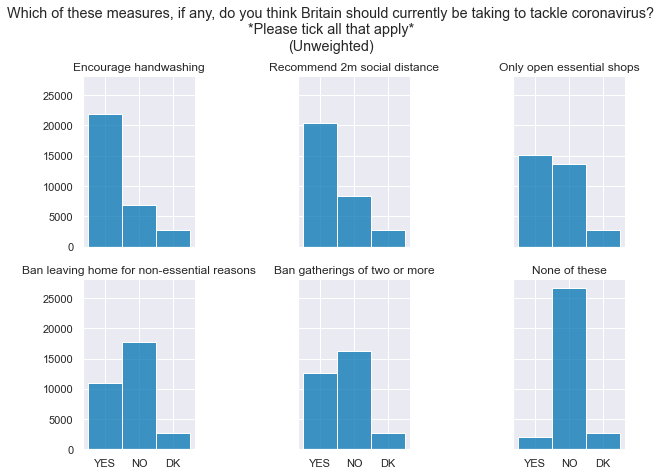

In [59]:
g = sns.FacetGrid(coronaMeasures, col="variable",col_wrap=3);
g.map_dataframe(sns.histplot, x="value",weights="wt");
g.set_titles(col_template="{col_name}");
g.fig.suptitle('Which of these measures, if any, do you think Britain should currently be taking to tackle coronavirus?\n*Please tick all that apply*\n(Unweighted)',y=1.10);

In [60]:
coronaMeasures = BES_Panel[search(BES_Panel,"coronaMeasures2_").index]
coronaMeasures["wt"] = BES_Panel["wt"]
coronaMeasures = coronaMeasures.melt(id_vars="wt")

coronaMeasures["variable"] = coronaMeasures["variable"].apply(lambda x: BESheader[x])
coronaMeasures["variable"] = coronaMeasures["variable"].apply(lambda x: x.replace("To tackle coronavirus Britain should: ",""))
coronaMeasures["value"] = coronaMeasures["value"].replace({"Don't know":"DK","No":"NO","Yes":"YES"})
coronaMeasures["value"] = coronaMeasures["value"].astype('category').cat.reorder_categories(["YES","NO","DK"])

# No/Yes/DK

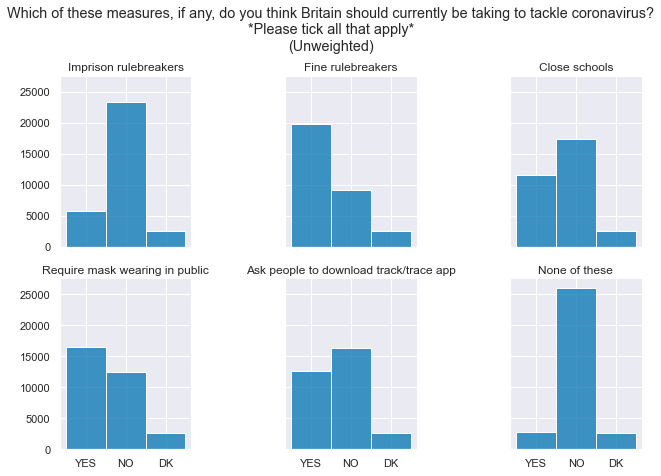

In [61]:
g = sns.FacetGrid(coronaMeasures, col="variable",col_wrap=3);
g.map_dataframe(sns.histplot, x="value",weights="wt");
g.set_titles(col_template="{col_name}");
g.fig.suptitle('Which of these measures, if any, do you think Britain should currently be taking to tackle coronavirus?\n*Please tick all that apply*\n(Unweighted)',y=1.10);

In [63]:
BES_reduced_with_na = BES_reduced_with_na.astype('float32')

## xgboost no like 'boolean'

In [126]:
BES_reduced_with_na

,turnoutUKGeneral__Very likely that I will vote,partyIdStrength__Not very strong,polAttention__Pay a great deal of attention,pidWeThey__Strongly agree,pidInterestedOthers__Strongly agree,pidCriticiseParty__Strongly agree,pidCommonParty__Strongly agree,pidRuinDay__Strongly agree,pidConnected__Strongly agree,pidMyParty__Strongly agree,...,responsibleEconC_7_Yes,responsibleEconC_6_Yes,responsibleEconC_5_Yes,responsibleEconC_4_Yes,responsibleEconC_3_Yes,responsibleEconC_2_Yes,responsibleEconC_1_Yes,coronaMeasures_2_Yes,coronaMeasures_1_Yes,coronaMeasures_4_Yes
id,,,,,,,,,,,,,,,,,,,,,
2,4.0,2.0,7.0,1.0,1.0,1.0,NaN,0.0,2.0,1.0,...,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0
7,4.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,4.0,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0
9,4.0,2.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0
15,4.0,0.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102854,4.0,0.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,0.0,1.0,0.0,1.0,1.0,0.0,0.0
102855,4.0,2.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,1.0,0.0,0.0,1.0,1.0,0.0
102856,4.0,1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,1.0,0.0


[0]	validation_0-rmse:3.87363
Will train until validation_0-rmse hasn't improved in 6.6000000000000005 rounds.
[1]	validation_0-rmse:3.74457
[2]	validation_0-rmse:3.60938
[3]	validation_0-rmse:3.48441
[4]	validation_0-rmse:3.36549
[5]	validation_0-rmse:3.26279
[6]	validation_0-rmse:3.15716
[7]	validation_0-rmse:3.06974
[8]	validation_0-rmse:2.97821
[9]	validation_0-rmse:2.89263
[10]	validation_0-rmse:2.82018
[11]	validation_0-rmse:2.75354
[12]	validation_0-rmse:2.69398
[13]	validation_0-rmse:2.62548
[14]	validation_0-rmse:2.57089
[15]	validation_0-rmse:2.51262
[16]	validation_0-rmse:2.45925
[17]	validation_0-rmse:2.40635
[18]	validation_0-rmse:2.36581
[19]	validation_0-rmse:2.32049
[20]	validation_0-rmse:2.28072
[21]	validation_0-rmse:2.24151
[22]	validation_0-rmse:2.20835
[23]	validation_0-rmse:2.17985
[24]	validation_0-rmse:2.1476
[25]	validation_0-rmse:2.11872
[26]	validation_0-rmse:2.09333
[27]	validation_0-rmse:2.06995
[28]	validation_0-rmse:2.04795
[29]	validation_0-rmse:2.02748


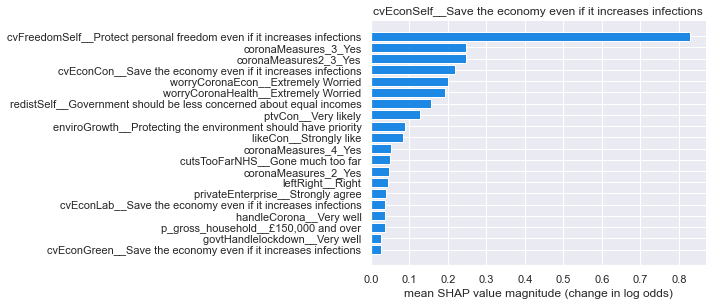

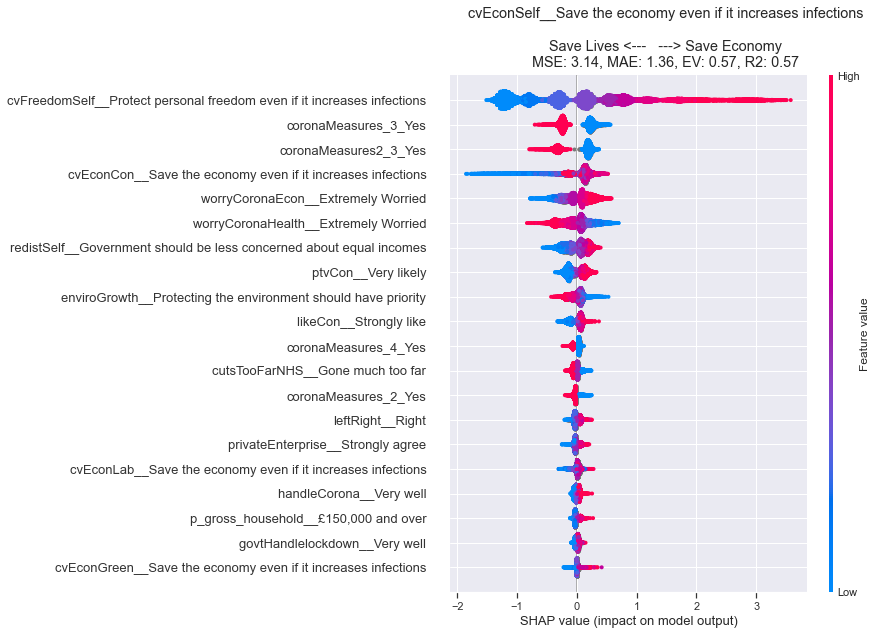

Wall time: 53.5 s


In [127]:
%%time

Treatment = "cvEconSelf"
var_stub = "cvEconSelf"

var_list = ["cvEconSelf__Save the economy even if it increases infections"]
var_stub_list = [var_stub]


colname = "cvEconSelf__Save the economy even if it increases infections"


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(
    subdir=colname,dataset=BES_reduced_with_na,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_reduced_with_na.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

[0]	validation_0-rmse:3.87304
Will train until validation_0-rmse hasn't improved in 30.400000000000002 rounds.
[1]	validation_0-rmse:3.74576
[2]	validation_0-rmse:3.62413
[3]	validation_0-rmse:3.50898
[4]	validation_0-rmse:3.39951
[5]	validation_0-rmse:3.29729
[6]	validation_0-rmse:3.20224
[7]	validation_0-rmse:3.11549
[8]	validation_0-rmse:3.03402
[9]	validation_0-rmse:2.95765
[10]	validation_0-rmse:2.88621
[11]	validation_0-rmse:2.82029
[12]	validation_0-rmse:2.7599
[13]	validation_0-rmse:2.69914
[14]	validation_0-rmse:2.647
[15]	validation_0-rmse:2.59745
[16]	validation_0-rmse:2.55185
[17]	validation_0-rmse:2.50478
[18]	validation_0-rmse:2.46563
[19]	validation_0-rmse:2.42536
[20]	validation_0-rmse:2.39199
[21]	validation_0-rmse:2.35687
[22]	validation_0-rmse:2.32459
[23]	validation_0-rmse:2.29745
[24]	validation_0-rmse:2.2685
[25]	validation_0-rmse:2.24232
[26]	validation_0-rmse:2.21967
[27]	validation_0-rmse:2.20005
[28]	validation_0-rmse:2.17912
[29]	validation_0-rmse:2.16143
[30

[259]	validation_0-rmse:1.83843
[260]	validation_0-rmse:1.83852
[261]	validation_0-rmse:1.83843
[262]	validation_0-rmse:1.83845
[263]	validation_0-rmse:1.83838
[264]	validation_0-rmse:1.83818
[265]	validation_0-rmse:1.83804
[266]	validation_0-rmse:1.83797
[267]	validation_0-rmse:1.83825
[268]	validation_0-rmse:1.83825
[269]	validation_0-rmse:1.83821
[270]	validation_0-rmse:1.83807
[271]	validation_0-rmse:1.83787
[272]	validation_0-rmse:1.83793
[273]	validation_0-rmse:1.8381
[274]	validation_0-rmse:1.8379
[275]	validation_0-rmse:1.83776
[276]	validation_0-rmse:1.8378
[277]	validation_0-rmse:1.83772
[278]	validation_0-rmse:1.83777
[279]	validation_0-rmse:1.83784
[280]	validation_0-rmse:1.83776
[281]	validation_0-rmse:1.8379
[282]	validation_0-rmse:1.83805
[283]	validation_0-rmse:1.83813
[284]	validation_0-rmse:1.83826
[285]	validation_0-rmse:1.83812
[286]	validation_0-rmse:1.83805
[287]	validation_0-rmse:1.83807
[288]	validation_0-rmse:1.83826
[289]	validation_0-rmse:1.83811
[290]	valida

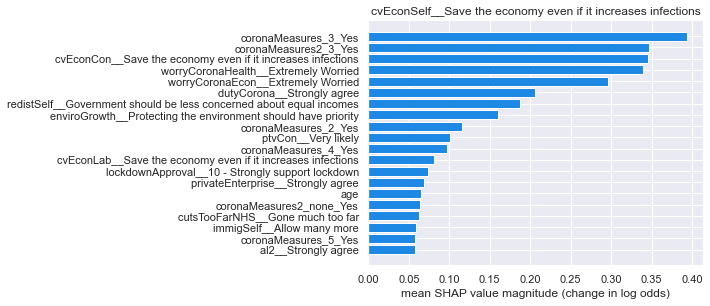

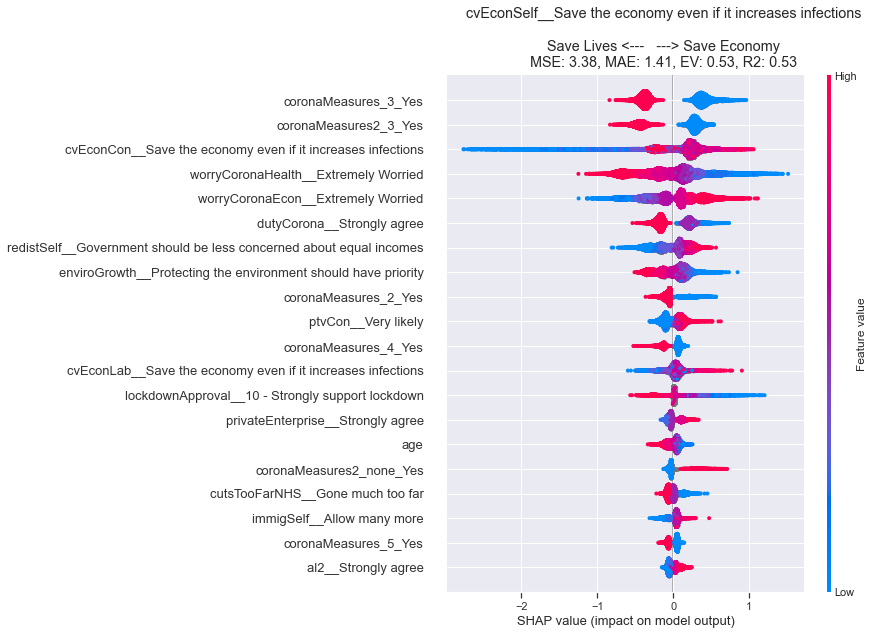

Wall time: 3min 48s


In [73]:
%%time
Treatment = "cvEconSelf_minusFreedomSelf"
var_stub = "cvEconSelf"

var_list = ["cvEconSelf__Save the economy even if it increases infections"]
var_stub_list = [var_stub,"cvFreedomSelf__Protect personal freedom even if it increases infections"]


colname = "cvEconSelf__Save the economy even if it increases infections"


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) =  xgboost_run(subdir=colname,dataset=BES_reduced_with_na,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_reduced_with_na.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

[0]	validation_0-rmse:3.8771
Will train until validation_0-rmse hasn't improved in 30.1 rounds.
[1]	validation_0-rmse:3.75174
[2]	validation_0-rmse:3.62978
[3]	validation_0-rmse:3.51595
[4]	validation_0-rmse:3.41116
[5]	validation_0-rmse:3.31143
[6]	validation_0-rmse:3.22151
[7]	validation_0-rmse:3.13644
[8]	validation_0-rmse:3.05548
[9]	validation_0-rmse:2.97866
[10]	validation_0-rmse:2.90718
[11]	validation_0-rmse:2.84276
[12]	validation_0-rmse:2.78301
[13]	validation_0-rmse:2.72549
[14]	validation_0-rmse:2.67321
[15]	validation_0-rmse:2.62392
[16]	validation_0-rmse:2.57896
[17]	validation_0-rmse:2.53677
[18]	validation_0-rmse:2.49881
[19]	validation_0-rmse:2.46284
[20]	validation_0-rmse:2.4294
[21]	validation_0-rmse:2.39948
[22]	validation_0-rmse:2.37063
[23]	validation_0-rmse:2.34454
[24]	validation_0-rmse:2.31876
[25]	validation_0-rmse:2.29688
[26]	validation_0-rmse:2.27559
[27]	validation_0-rmse:2.25623
[28]	validation_0-rmse:2.2382
[29]	validation_0-rmse:2.22162
[30]	validation_

[259]	validation_0-rmse:1.99406
[260]	validation_0-rmse:1.99401
[261]	validation_0-rmse:1.99392
[262]	validation_0-rmse:1.9939
[263]	validation_0-rmse:1.99397
[264]	validation_0-rmse:1.99398
[265]	validation_0-rmse:1.99399
[266]	validation_0-rmse:1.99401
[267]	validation_0-rmse:1.99407
[268]	validation_0-rmse:1.9942
[269]	validation_0-rmse:1.9941
[270]	validation_0-rmse:1.9942
[271]	validation_0-rmse:1.99404
[272]	validation_0-rmse:1.99394
[273]	validation_0-rmse:1.99381
[274]	validation_0-rmse:1.99381
[275]	validation_0-rmse:1.99368
[276]	validation_0-rmse:1.99374
[277]	validation_0-rmse:1.99374
[278]	validation_0-rmse:1.99391
[279]	validation_0-rmse:1.99401
[280]	validation_0-rmse:1.99406
[281]	validation_0-rmse:1.99402
[282]	validation_0-rmse:1.9939
[283]	validation_0-rmse:1.99375
[284]	validation_0-rmse:1.99383
[285]	validation_0-rmse:1.99383
[286]	validation_0-rmse:1.99383
[287]	validation_0-rmse:1.99371
[288]	validation_0-rmse:1.99382
Stopping. Best iteration:
[257]	validation_0-

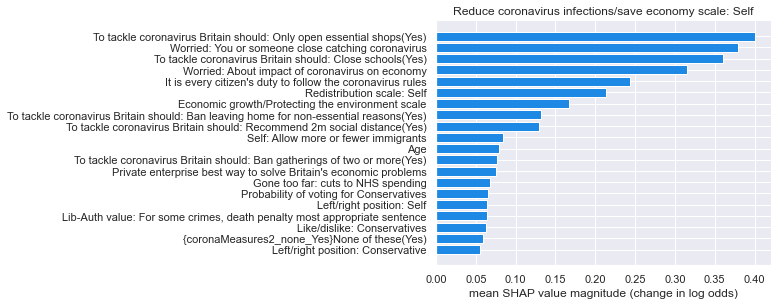

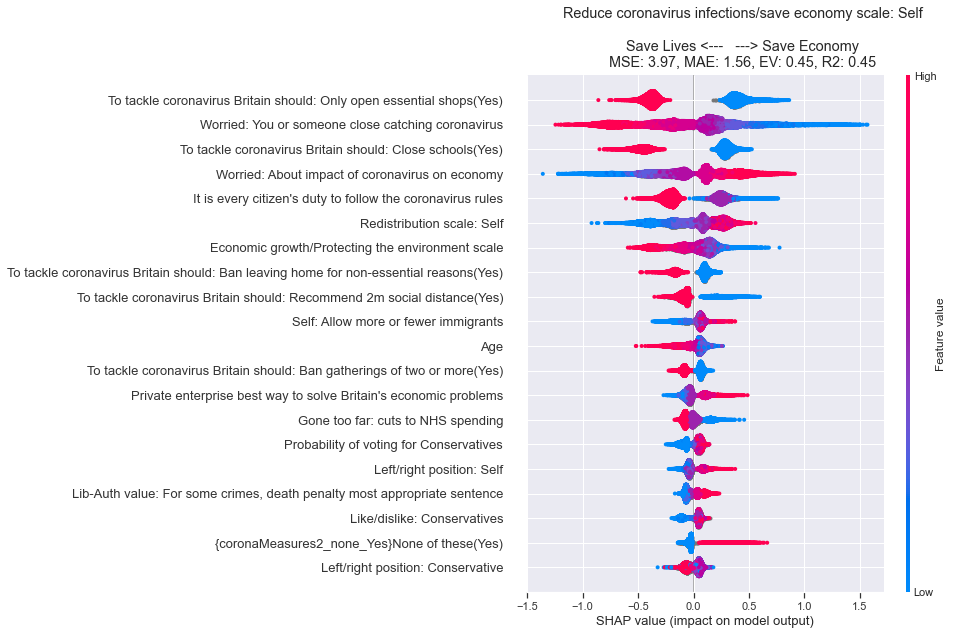

Wall time: 3min 4s


In [74]:
%%time
Treatment = "cvEconSelf_minusFreedomSelf"
# var_stub = "cvEconSelf"

# var_list = ["cvEconSelf__Save the economy even if it increases infections"]
# var_stub_list = [var_stub,
#                  "cvFreedomSelf__Protect personal freedom even if it increases infections",
#                  "cvEcon","lockdownApproval"]


# colname = "cvEconSelf__Save the economy even if it increases infections"

colname = 'Reduce coronavirus infections/save economy scale: Self'
var_stub = 'Reduce coronavirus infections/save economy scale'
var_list = ['Reduce coronavirus infections/save economy scale: Self']
var_stub_list = [var_stub,"Yourself","Lockdown approval"]

first_run = pd.Series([useBESheaders(x) for x in BES_reduced_with_na.columns]).value_counts()
new_cols = pd.Series([useBESheaders(x,first_run[first_run>1].index) for x in BES_reduced_with_na.columns])
BES_vals = BES_reduced_with_na.copy()
BES_vals.columns = new_cols


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) =  xgboost_run(subdir=colname,dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

In [68]:
# BES_reduced_with_na.columns[BES_vals.columns=="Yourself"]

In [ ]:
# [x.replace("â\x80\x99","'") for x in BESheader.values() if "It is every" in x]

In [ ]:
# BESheader.values()

In [75]:
# BESheader["coronaMeasures_2"]
# BESheader["_".join('coronaMeasures_2_Yes'.split("_")[:-1])]+"("+'coronaMeasures_2_Yes'.split("_")[-1]+")"

In [76]:
# BES_vals = BES_reduced_with_na.copy()
# BES_vals.columns = new_cols

# search(BES_vals,"Reduce coronavirus infections")

In [ ]:
# Authoritarian effect
# Redistribution effect





In [77]:
# # |redistSelf
# value_list = list( search(BES_reduced_with_na, "(al|lr)(\d|_scale)" ).index )
# value_list.append("cvEconSelf__Save the economy even if it increases infections")

# BES_vals = BES_reduced_with_na[value_list]
# BES_vals.columns = [BESheader[ x.split("__")[0] ] for x in BES_vals.columns]

[0]	validation_0-rmse:3.89391
Will train until validation_0-rmse hasn't improved in 25.700000000000003 rounds.
[1]	validation_0-rmse:3.78318
[2]	validation_0-rmse:3.67964
[3]	validation_0-rmse:3.5846
[4]	validation_0-rmse:3.49566
[5]	validation_0-rmse:3.41345
[6]	validation_0-rmse:3.33835
[7]	validation_0-rmse:3.26939
[8]	validation_0-rmse:3.20403
[9]	validation_0-rmse:3.14449
[10]	validation_0-rmse:3.08964
[11]	validation_0-rmse:3.04
[12]	validation_0-rmse:2.99327
[13]	validation_0-rmse:2.95052
[14]	validation_0-rmse:2.91117
[15]	validation_0-rmse:2.87571
[16]	validation_0-rmse:2.84268
[17]	validation_0-rmse:2.81275
[18]	validation_0-rmse:2.78539
[19]	validation_0-rmse:2.76068
[20]	validation_0-rmse:2.73763
[21]	validation_0-rmse:2.71679
[22]	validation_0-rmse:2.69753
[23]	validation_0-rmse:2.68019
[24]	validation_0-rmse:2.66421
[25]	validation_0-rmse:2.64997
[26]	validation_0-rmse:2.63675
[27]	validation_0-rmse:2.62504
[28]	validation_0-rmse:2.61429
[29]	validation_0-rmse:2.6047
[30]

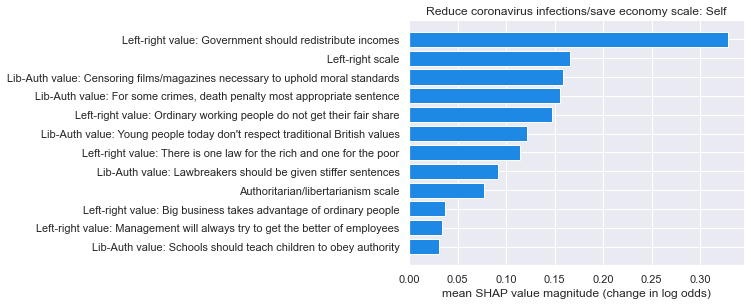

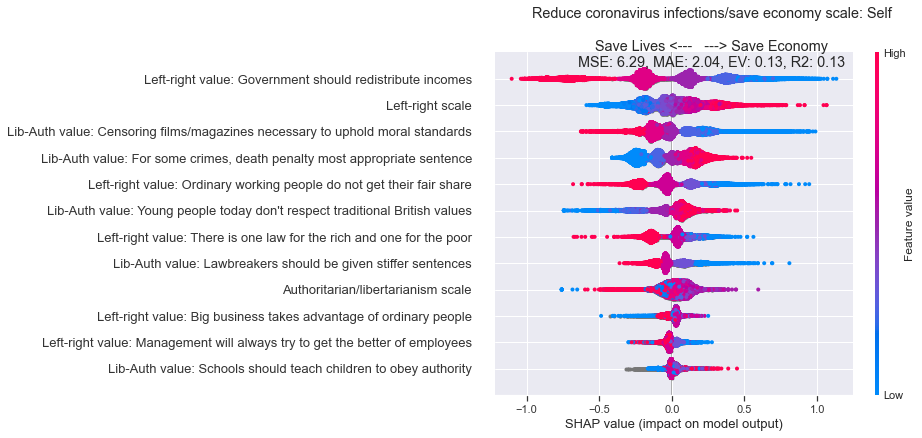

Wall time: 33.3 s


In [78]:
%%time

Treatment = "cvEconSelf_values_only"


# |redistSelf
value_list = list( search(BES_reduced_with_na, "(al|lr)(\d|_scale)" ).index )
value_list.append("cvEconSelf__Save the economy even if it increases infections")

BES_vals = BES_reduced_with_na[value_list]
# BES_vals.columns = [BESheader[ x.split("__")[0] ] for x in BES_vals.columns]
BES_vals.columns = [BESheader[ new_old_col_names[x] ] for x in BES_vals.columns]

colname = 'Reduce coronavirus infections/save economy scale: Self'
var_stub = 'Reduce coronavirus infections/save economy scale: Self'
var_list = ['Reduce coronavirus infections/save economy scale: Self']
var_stub_list = [var_stub,]


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(subdir=colname,dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

[0]	validation_0-rmse:3.89739
Will train until validation_0-rmse hasn't improved in 9.0 rounds.
[1]	validation_0-rmse:3.78755
[2]	validation_0-rmse:3.68501
[3]	validation_0-rmse:3.59083
[4]	validation_0-rmse:3.50427
[5]	validation_0-rmse:3.42223
[6]	validation_0-rmse:3.34693
[7]	validation_0-rmse:3.27752
[8]	validation_0-rmse:3.21427
[9]	validation_0-rmse:3.15455
[10]	validation_0-rmse:3.10054
[11]	validation_0-rmse:3.05069
[12]	validation_0-rmse:3.00346
[13]	validation_0-rmse:2.96059
[14]	validation_0-rmse:2.92196
[15]	validation_0-rmse:2.88759
[16]	validation_0-rmse:2.85475
[17]	validation_0-rmse:2.82395
[18]	validation_0-rmse:2.7961
[19]	validation_0-rmse:2.77061
[20]	validation_0-rmse:2.74752
[21]	validation_0-rmse:2.7271
[22]	validation_0-rmse:2.70751
[23]	validation_0-rmse:2.68945
[24]	validation_0-rmse:2.67347
[25]	validation_0-rmse:2.65943
[26]	validation_0-rmse:2.6457
[27]	validation_0-rmse:2.63352
[28]	validation_0-rmse:2.62268
[29]	validation_0-rmse:2.61209
[30]	validation_0

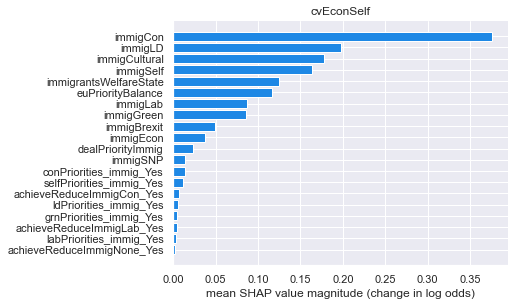

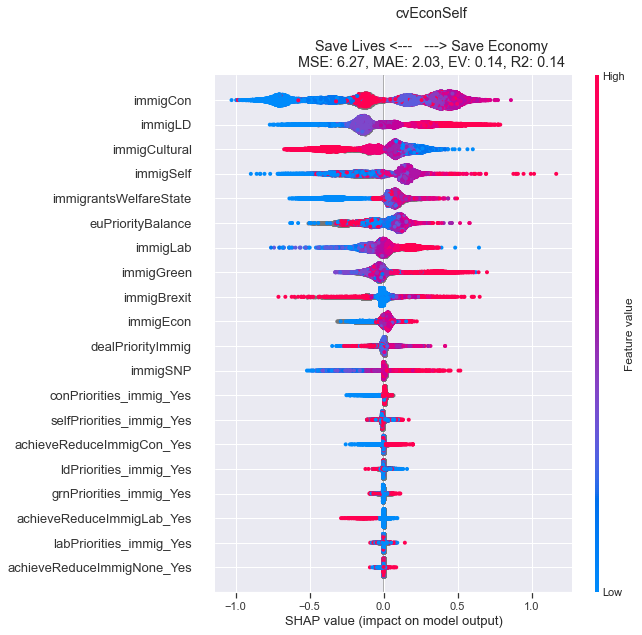

Wall time: 30.5 s


In [79]:
%%time

value_list = list( search(BES_reduced_with_na, "immig" ).index )
value_list.append("cvEconSelf__Save the economy even if it increases infections")

Treatment = "cvEconSelf_values_only"


BES_vals = BES_reduced_with_na[value_list]
BES_vals.columns = [ x.split("__")[0] for x in BES_vals.columns]

focal_var = "cvEconSelf"


var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub,]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(subdir=colname,dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

[0]	validation_0-rmse:3.90115
Will train until validation_0-rmse hasn't improved in 8.700000000000001 rounds.
[1]	validation_0-rmse:3.79677
[2]	validation_0-rmse:3.69894
[3]	validation_0-rmse:3.60814
[4]	validation_0-rmse:3.5249
[5]	validation_0-rmse:3.44755
[6]	validation_0-rmse:3.37614
[7]	validation_0-rmse:3.3098
[8]	validation_0-rmse:3.24819
[9]	validation_0-rmse:3.1918
[10]	validation_0-rmse:3.14027
[11]	validation_0-rmse:3.09353
[12]	validation_0-rmse:3.05075
[13]	validation_0-rmse:3.01085
[14]	validation_0-rmse:2.97476
[15]	validation_0-rmse:2.94162
[16]	validation_0-rmse:2.91094
[17]	validation_0-rmse:2.8827
[18]	validation_0-rmse:2.85738
[19]	validation_0-rmse:2.8349
[20]	validation_0-rmse:2.81376
[21]	validation_0-rmse:2.79393
[22]	validation_0-rmse:2.77476
[23]	validation_0-rmse:2.75824
[24]	validation_0-rmse:2.74332
[25]	validation_0-rmse:2.73032
[26]	validation_0-rmse:2.71732
[27]	validation_0-rmse:2.70596
[28]	validation_0-rmse:2.6958
[29]	validation_0-rmse:2.68619
[30]	v

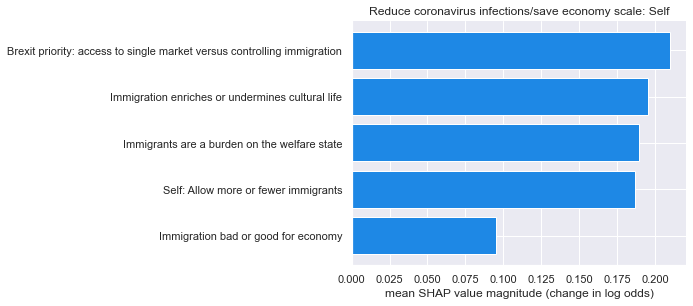

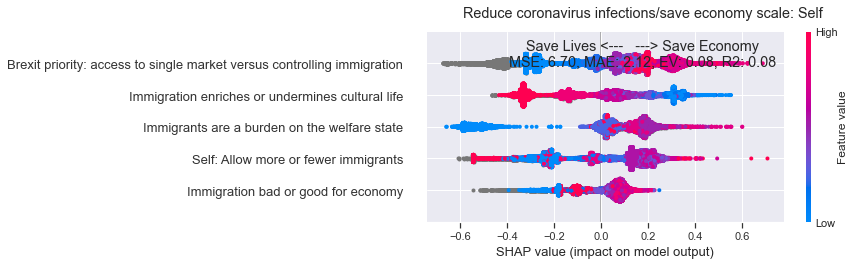

Wall time: 9.66 s


In [80]:
%%time

value_list = list( search(BES_reduced_with_na, "immig(Cultural|Econ|Self)|euPriorityBalance|immigrantsWelfareState" ).index )
value_list.append("cvEconSelf__Save the economy even if it increases infections")

Treatment = "cvEconSelf_values_only"


BES_vals = BES_reduced_with_na[value_list]
BES_vals.columns = [BESheader[ new_old_col_names[x] ] for x in BES_vals.columns]

focal_var = 'Reduce coronavirus infections/save economy scale: Self'


var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub,]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(subdir=colname,dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

In [83]:
BES_vals = BES_reduced_with_na.copy()
BES_vals.columns = [useBESheaders(x) for x in BES_vals.columns]

In [85]:
first_run = pd.Series([useBESheaders(x) for x in BES_reduced_with_na.columns]).value_counts()
new_cols = pd.Series([useBESheaders(x,first_run[first_run>1].index) for x in BES_reduced_with_na.columns])
BES_vals = BES_reduced_with_na.copy()
BES_vals.columns = new_cols

[0]	validation_0-rmse:5.92353
Will train until validation_0-rmse hasn't improved in 7.9 rounds.
[1]	validation_0-rmse:5.69115
[2]	validation_0-rmse:5.47419
[3]	validation_0-rmse:5.26959
[4]	validation_0-rmse:5.07795
[5]	validation_0-rmse:4.89856
[6]	validation_0-rmse:4.7305
[7]	validation_0-rmse:4.5731
[8]	validation_0-rmse:4.42596
[9]	validation_0-rmse:4.28831
[10]	validation_0-rmse:4.16125
[11]	validation_0-rmse:4.0404
[12]	validation_0-rmse:3.92977
[13]	validation_0-rmse:3.82628
[14]	validation_0-rmse:3.72959
[15]	validation_0-rmse:3.64116
[16]	validation_0-rmse:3.55834
[17]	validation_0-rmse:3.48176
[18]	validation_0-rmse:3.41116
[19]	validation_0-rmse:3.345
[20]	validation_0-rmse:3.28501
[21]	validation_0-rmse:3.22874
[22]	validation_0-rmse:3.17788
[23]	validation_0-rmse:3.13054
[24]	validation_0-rmse:3.0867
[25]	validation_0-rmse:3.04736
[26]	validation_0-rmse:3.01061
[27]	validation_0-rmse:2.97679
[28]	validation_0-rmse:2.946
[29]	validation_0-rmse:2.91766
[30]	validation_0-rmse

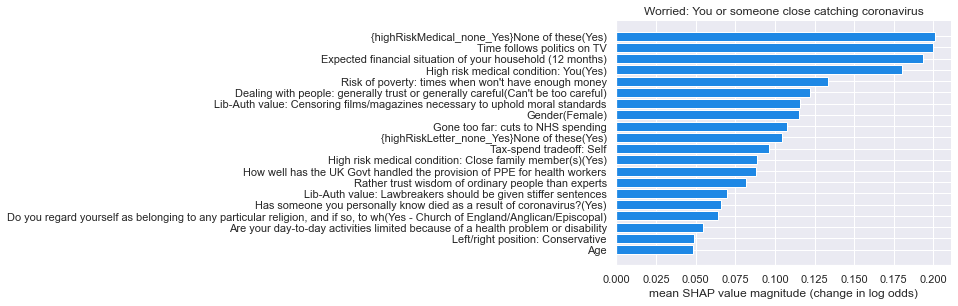

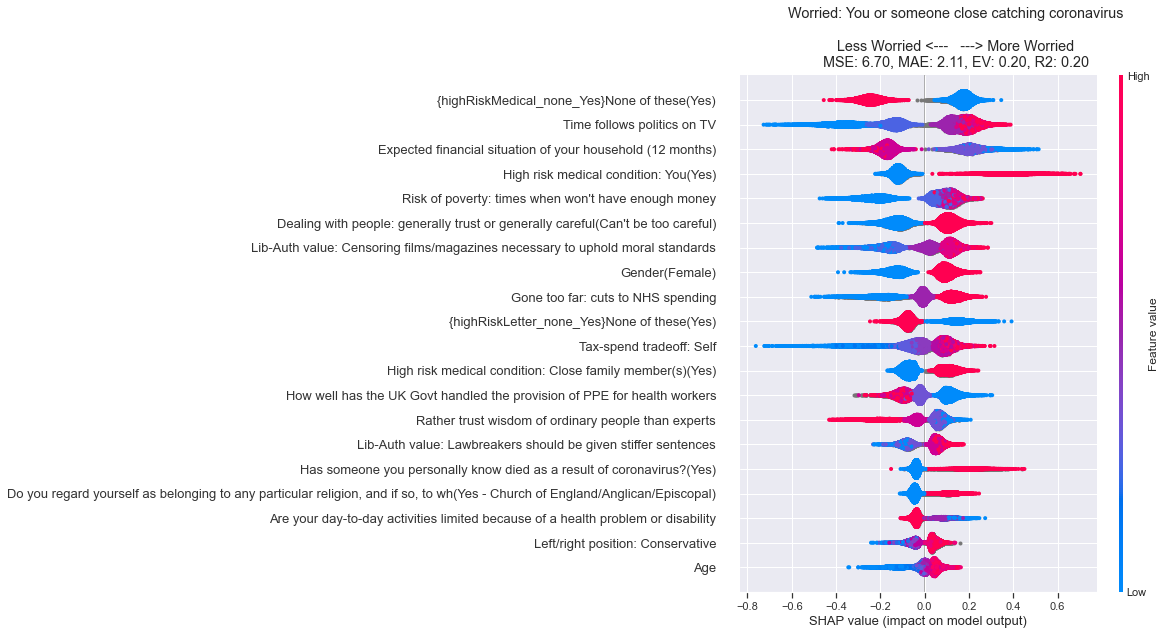

Wall time: 1min 9s


In [99]:
%%time

# value_list = list( search(BES_reduced_with_na, "immig(Cultural|Econ|Self)|euPriorityBalance|immigrantsWelfareState" ).index )
# value_list.append("cvEconSelf__Save the economy even if it increases infections")

Treatment = "worryCoronaHealth"


# BES_vals = BES_reduced_with_na[value_list]
# BES_vals.columns = [BESheader[ new_old_col_names[x] ] for x in BES_vals.columns]

focal_var = 'Worried: You or someone close catching coronavirus'


var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub,"Worried","Yourself","Reduce coronavirus infections","To tackle coronavirus",
                "It is every citizen's duty to follow the coronavirus rules","coronaMeasures",
                "The coronavirus crisis getting better or worse","Lockdown approval"]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(
            subdir=colname,
            dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nLess Worried <---   ---> More Worried")

[0]	validation_0-rmse:2.90639
Will train until validation_0-rmse hasn't improved in 7.7 rounds.
[1]	validation_0-rmse:2.77193
[2]	validation_0-rmse:2.64448
[3]	validation_0-rmse:2.5241
[4]	validation_0-rmse:2.40988
[5]	validation_0-rmse:2.3018
[6]	validation_0-rmse:2.19968
[7]	validation_0-rmse:2.10325
[8]	validation_0-rmse:2.01229
[9]	validation_0-rmse:1.9264
[10]	validation_0-rmse:1.84559
[11]	validation_0-rmse:1.76935
[12]	validation_0-rmse:1.69735
[13]	validation_0-rmse:1.62972
[14]	validation_0-rmse:1.5659
[15]	validation_0-rmse:1.50614
[16]	validation_0-rmse:1.45
[17]	validation_0-rmse:1.39734
[18]	validation_0-rmse:1.34788
[19]	validation_0-rmse:1.30124
[20]	validation_0-rmse:1.25786
[21]	validation_0-rmse:1.21724
[22]	validation_0-rmse:1.17947
[23]	validation_0-rmse:1.14421
[24]	validation_0-rmse:1.11146
[25]	validation_0-rmse:1.08097
[26]	validation_0-rmse:1.05284
[27]	validation_0-rmse:1.02643
[28]	validation_0-rmse:1.00181
[29]	validation_0-rmse:0.97909
[30]	validation_0-rms

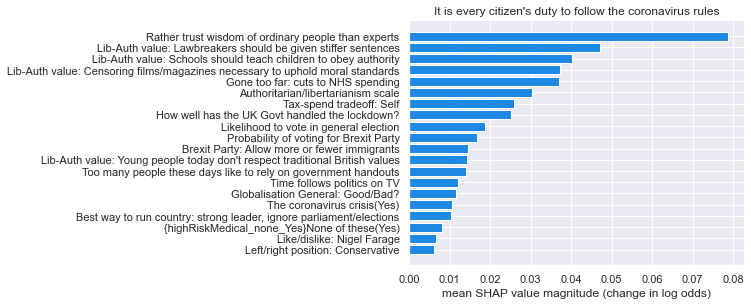

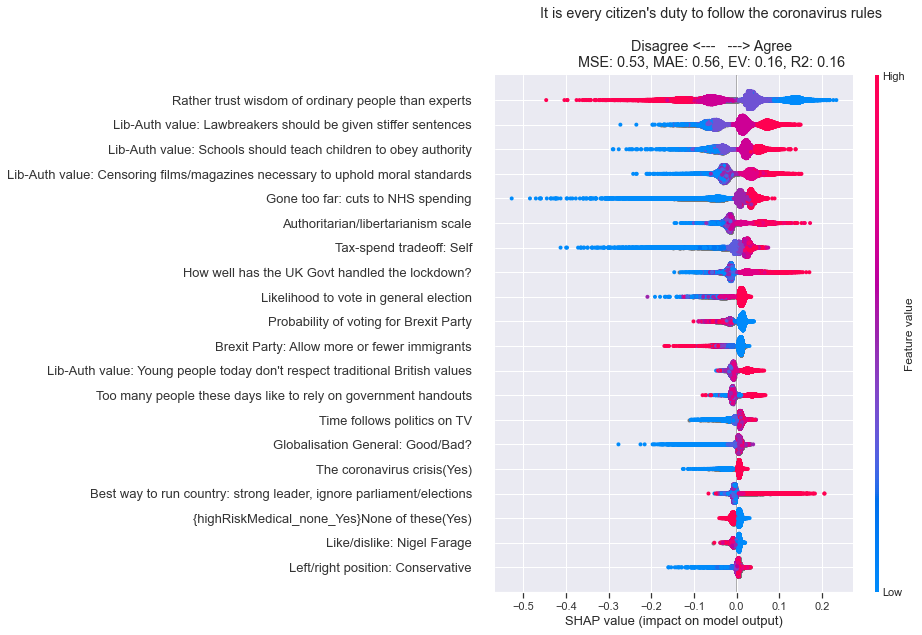

Wall time: 1min 5s


In [101]:
%%time
## Strong (Left?)Authoritarian pitch towards "people should obey rules"
## Visible Right-Authoritarian

Treatment = "dutyCorona"


# BES_vals = BES_reduced_with_na[value_list]
# BES_vals.columns = [BESheader[ new_old_col_names[x] ] for x in BES_vals.columns]

focal_var = "It is every citizen's duty to follow the coronavirus rules"


var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub ,"Worried","Yourself","Reduce coronavirus infections","To tackle coronavirus",
                  "coronaMeasures",
                  "The coronavirus crisis getting better or worse","Lockdown approval"]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(
            subdir=colname,
            dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nDisagree <---   ---> Agree")

[0]	validation_0-rmse:3.90316
Will train until validation_0-rmse hasn't improved in 6.800000000000001 rounds.
[1]	validation_0-rmse:3.80048
[2]	validation_0-rmse:3.7052
[3]	validation_0-rmse:3.6176
[4]	validation_0-rmse:3.5372
[5]	validation_0-rmse:3.46206
[6]	validation_0-rmse:3.39309
[7]	validation_0-rmse:3.32975
[8]	validation_0-rmse:3.27095
[9]	validation_0-rmse:3.2175
[10]	validation_0-rmse:3.16827
[11]	validation_0-rmse:3.12333
[12]	validation_0-rmse:3.08176
[13]	validation_0-rmse:3.04391
[14]	validation_0-rmse:3.00987
[15]	validation_0-rmse:2.97842
[16]	validation_0-rmse:2.94979
[17]	validation_0-rmse:2.92348
[18]	validation_0-rmse:2.89949
[19]	validation_0-rmse:2.87784
[20]	validation_0-rmse:2.85809
[21]	validation_0-rmse:2.84004
[22]	validation_0-rmse:2.82311
[23]	validation_0-rmse:2.808
[24]	validation_0-rmse:2.79427
[25]	validation_0-rmse:2.78192
[26]	validation_0-rmse:2.7708
[27]	validation_0-rmse:2.76092
[28]	validation_0-rmse:2.75206
[29]	validation_0-rmse:2.74372
[30]	va

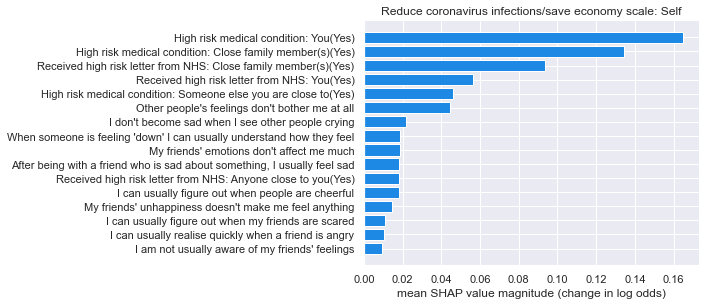

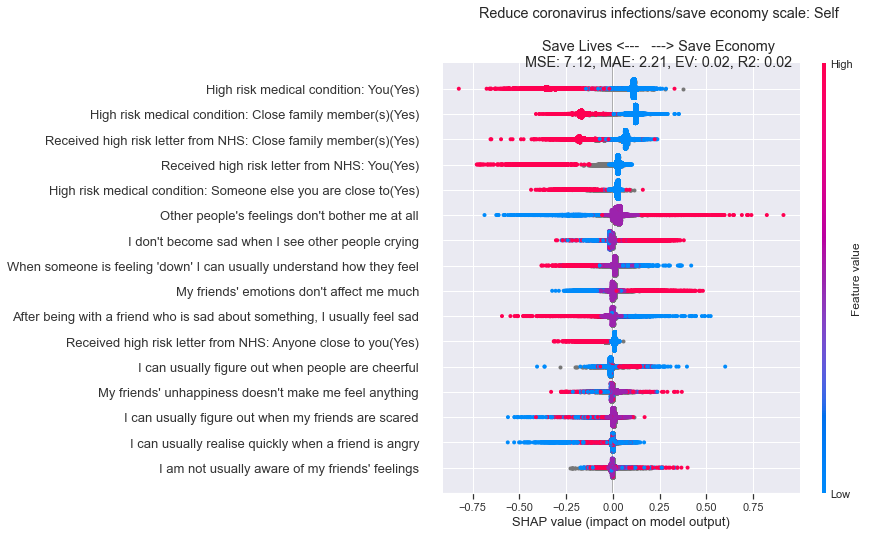

In [118]:
value_list = list( search(BES_reduced_with_na, "empathy|highrisk" ).index )
value_list.append("cvEconSelf__Save the economy even if it increases infections")

Treatment = "cvEconSelf_empathy_only"

BES_vals = BES_reduced_with_na[value_list]
BES_vals.columns = [useBESheaders(x) for x in BES_vals.columns]

focal_var = 'Reduce coronavirus infections/save economy scale: Self'

var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub,"None of these(Yes)"]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(
            subdir=colname,
            dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

[0]	validation_0-rmse:5.92655
Will train until validation_0-rmse hasn't improved in 6.7 rounds.
[1]	validation_0-rmse:5.69904
[2]	validation_0-rmse:5.48569
[3]	validation_0-rmse:5.28502
[4]	validation_0-rmse:5.09696
[5]	validation_0-rmse:4.92166
[6]	validation_0-rmse:4.75746
[7]	validation_0-rmse:4.60506
[8]	validation_0-rmse:4.46215
[9]	validation_0-rmse:4.32854
[10]	validation_0-rmse:4.20549
[11]	validation_0-rmse:4.09
[12]	validation_0-rmse:3.98322
[13]	validation_0-rmse:3.88414
[14]	validation_0-rmse:3.79194
[15]	validation_0-rmse:3.7065
[16]	validation_0-rmse:3.62779
[17]	validation_0-rmse:3.55567
[18]	validation_0-rmse:3.48917
[19]	validation_0-rmse:3.42764
[20]	validation_0-rmse:3.37137
[21]	validation_0-rmse:3.3191
[22]	validation_0-rmse:3.27164
[23]	validation_0-rmse:3.22779
[24]	validation_0-rmse:3.18764
[25]	validation_0-rmse:3.15103
[26]	validation_0-rmse:3.11822
[27]	validation_0-rmse:3.08768
[28]	validation_0-rmse:3.06022
[29]	validation_0-rmse:3.03508
[30]	validation_0-r

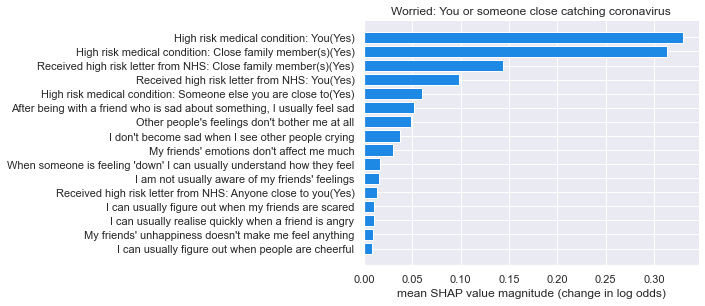

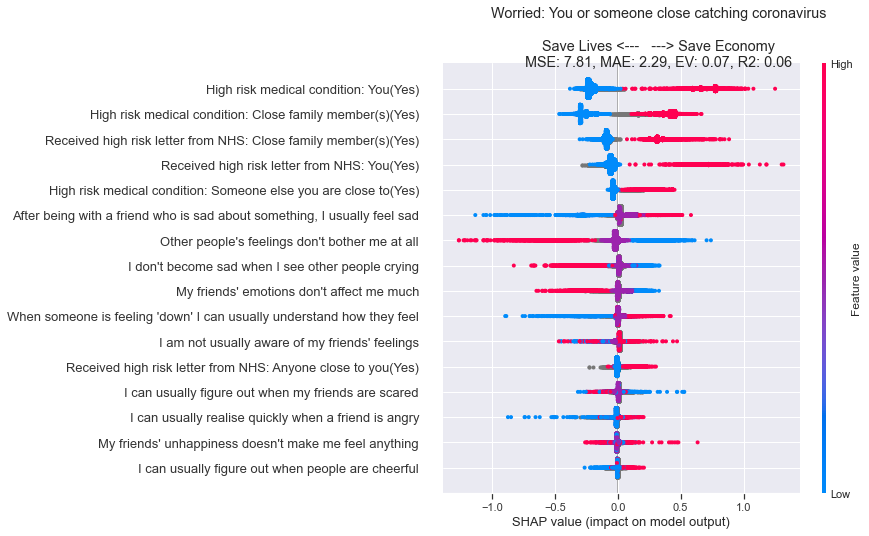

In [124]:
value_list = list( search(BES_reduced_with_na, "empathy|highrisk" ).index )



Treatment = "worryCoronaHealth_empathy_only"


value_list.append("worryCoronaHealth__Extremely Worried")
focal_var = 'Worried: You or someone close catching coronavirus'


BES_vals = BES_reduced_with_na[value_list]
BES_vals.columns = [useBESheaders(x) for x in BES_vals.columns]



var_list = [focal_var]
var_stub = focal_var
var_stub_list = [var_stub,"None of these(Yes)"]


colname = focal_var


(explainer, shap_values, train_columns, train_index, alg, output_subfolder) = xgboost_run(
            subdir=colname,
            dataset=BES_vals,
            var_list=var_list,var_stub_list=var_stub_list,
            min_features = min(BES_vals.shape[1]-1,20),
            title = colname+"\n\nSave Lives <---   ---> Save Economy")

In [ ]:
search(BES_reduced_with_na,"corona")

In [121]:
BESheader["worryCoronaHealth"]

'Worried: You or someone close catching coronavirus'